In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import matplotlib
import random
import ray

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    })

dataset_names = [
    'KGRec',
    'MovieLens',
    'Netflix',
    'Spotify',
]


In [108]:
kgrec_music_df = pd.read_csv('../datasets/kgrec/music_ratings.csv.gz')
ml_df = pd.read_csv('../datasets/movie_lens/ratings.csv.gz')
netflix_df = pd.read_csv(f'../datasets/netflix/ratings.csv.gz')
spotify_df = pd.read_csv(f'../datasets/spotify/ratings.csv.gz')
spotify_df.rename(columns={'playlist_id': 'user_id'}, inplace=True)

ratings_datasets = [
    ('KGRec', kgrec_music_df, True),
    ('MovieLens', ml_df, False),
    ('Netflix', netflix_df, True),
    ('Spotify', spotify_df, True),
]

In [109]:
# check sizes of datasets in gb
for dataset_name, dataset_df, _ in ratings_datasets:
    total_mem_usage = dataset_df.memory_usage(deep=True, index=True).sum()
    total_mem_usage_gb = round(total_mem_usage / 1024 ** 3, 2)
    print(f'{dataset_name} {total_mem_usage_gb} gb')

KGRec 0.01 gb
MovieLens 0.75 gb
Netflix 8.52 gb
Spotify 0.99 gb


In [110]:
def check_if_ids_sequential(dataset_df):
    max_user_id = dataset_df['user_id'].max()
    max_item_id = dataset_df['item_id'].max()
    count_user_id = dataset_df['user_id'].nunique()
    count_item_id = dataset_df['item_id'].nunique()

    print(f'Max user id: {max_user_id}')
    print(f'Max item id: {max_item_id}')
    print(f'Count user id: {count_user_id}')
    print(f'Count item id: {count_item_id}')

    assert  max_user_id == (count_user_id - 1)
    assert  max_item_id == (count_item_id - 1)

for dataset_name, dataset_df, _ in ratings_datasets:
    print(f'Checking if {dataset_name} dataset is sequential...')
    check_if_ids_sequential(dataset_df)

Checking if KGRec dataset is sequential...
Max user id: 5198
Max item id: 8639
Count user id: 5199
Count item id: 8640
Checking if MovieLens dataset is sequential...
Max user id: 162540
Max item id: 59046
Count user id: 162541
Count item id: 59047
Checking if Netflix dataset is sequential...
Max user id: 480188
Max item id: 17769
Count user id: 480189
Count item id: 17770
Checking if Spotify dataset is sequential...
Max user id: 999999
Max item id: 2262291
Count user id: 1000000
Count item id: 2262292


In [ ]:
ray.init(num_cpus=os.cpu_count())

In [ ]:
from scipy.sparse import lil_array
from scipy.sparse import save_npz

# create dir
if not os.path.exists('npz/sparse_datasets'):
    os.makedirs('npz/sparse_datasets')

def transform_to_sparse_matrix(dataset_df):
    max_user_id = dataset_df['user_id'].max()
    max_item_id = dataset_df['item_id'].max()

    has_rating = 'rating' in dataset_df.columns

    users_to_items_ratings = lil_array((max_user_id + 1, max_item_id + 1), dtype=np.float32)
    
    if has_rating:
        for user_id, item_id, rating, *_ in tqdm(dataset_df.itertuples(index=False), total=dataset_df.shape[0]):
            users_to_items_ratings[user_id, item_id] = rating
    else:
        for user_id, item_id, *_ in tqdm(dataset_df.itertuples(index=False), total=dataset_df.shape[0]):
            users_to_items_ratings[user_id, item_id] = 1
    
    users_to_items_ratings = users_to_items_ratings.tocsr()
    save_npz(f'npz/sparse_datasets/{dataset_name}_users_to_items_ratings.npz', users_to_items_ratings)
    return users_to_items_ratings

ratings_datasets_w_sparse = []

for dataset_name, dataset_df, _ in ratings_datasets:
    ratings_datasets_w_sparse.append((dataset_name, dataset_df, transform_to_sparse_matrix(dataset_df)))

#### LOAD saved sparse matricies


In [6]:
from scipy.sparse import load_npz

ratings_datasets_w_sparse = []

for dataset_name, dataset_df, _ in ratings_datasets:
    print(f'Loading {dataset_name} dataset...')
    users_to_items_ratings = load_npz(f'npz/sparse_datasets/{dataset_name}_users_to_items_ratings.npz')
    ratings_datasets_w_sparse.append((dataset_name, dataset_df, users_to_items_ratings))

Loading KGRec dataset...
Loading MovieLens dataset...
Loading Netflix dataset...
Loading Spotify dataset...


---
## Sample the similarity
run only once, if ran skip

In [ ]:
from more_itertools import chunked


def get_random_users(max):
    while True:
        u1, u2 = random.randint(0, max), random.randint(0, max)
        if u1 != u2:
            return u1, u2

@ray.remote
def calculate_similarity(u1_ratings, u2_ratings):
    u1_n = u1_ratings.dot(u1_ratings.T)[0, 0]
    if(u1_n == 0):
        return 0
    u2_n = u2_ratings.dot(u2_ratings.T)[0, 0]
    if(u2_n == 0):
        return 0
    denominator = np.sqrt(u1_n) * np.sqrt(u2_n)
    nomimator = u1_ratings.dot(u2_ratings.T)[0,0]
    result = nomimator / denominator
    return result


def draw_random_samples(dataset_df, our_sparse_rating_dataset, num_samples):
    max_user_id = dataset_df['user_id'].max()

    samples = []
    random_tuples = list(map(lambda _: get_random_users(max_user_id), range(num_samples)))

    # take 1000 random samples
    with tqdm(total=num_samples) as progress_bar:
        for chunk in chunked(random_tuples, 1000):
            ray_results = []
            for u1, u2 in chunk:
                u1_ratings = our_sparse_rating_dataset.getrow(u1)
                u2_ratings = our_sparse_rating_dataset.getrow(u2)
                ray_results.append(calculate_similarity.remote(u1_ratings, u2_ratings))
            results = ray.get(ray_results)
            samples.extend(results)
            progress_bar.update(len(results))
    return samples
    
datasets_samples = {}

num_samples = 100_000

dir = os.path.join('dfs', 'samples', str(num_samples))

if not os.path.exists(dir):
    os.makedirs(dir)

for dataset_name, dataset_df, ratings_sparse in ratings_datasets_w_sparse:
    print(f'Processing {dataset_name}')
    samples = draw_random_samples(dataset_df, ratings_sparse, num_samples=num_samples)
    df = pd.DataFrame(samples, columns=['similarity'])
    df.to_csv(os.path.join(dir, f'{dataset_name}.csv'), index=False)
    datasets_samples[dataset_name] = samples

---
# Read the saved sampled similarities and fit exp

In [111]:
# read the saved sample files
dataset_names = [
    'MovieLens',
    'KGRec',
    'Netflix',
    'Spotify'
    ]

datasets_samples = {}
for dataset_name in dataset_names:
    samples_df = pd.read_csv(os.path.join('dfs', 'samples', '1000000', f'{dataset_name}.csv'))
    datasets_samples[dataset_name] = samples_df

In [112]:
import scipy.stats as ss
def model_using_exp(samples):
    exp_params = ss.expon.fit(samples, method='MM')
    (e1, e2) = exp_params
    exp_params = (0, e2)
    return exp_params

datasets_modeled_params = {}
    
for dataset_name, samples_df in datasets_samples.items():
    print(f'Processing {dataset_name}')
    samples = list(samples_df[samples_df['similarity'] != 0]['similarity'])
    exp_params = model_using_exp(samples)
    datasets_modeled_params[dataset_name] = exp_params
    print(f'{dataset_name}: {exp_params}')

Processing MovieLens
MovieLens: (0, 0.0867687386394521)
Processing KGRec
KGRec: (0, 0.046808461329693)
Processing Netflix
Netflix: (0, 0.08737692913250775)
Processing Spotify
Spotify: (0, 0.03239531399168339)


In [113]:
random_sample_size = 1_000_000
num_intervals = 10

def test_model(exp_params, num_intervals, random_sample_size):
    for i in range(num_intervals):
        start = (1/num_intervals) * i
        end = (1/num_intervals * (i+1))
        prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
        pdf = ss.expon.pdf(start, *exp_params)
        print(f'[{round(start,2)},{round(end,2)}] => {prob_on_interval}, samples: {int(prob_on_interval * random_sample_size)},  pdf: {pdf}')

for dataset_name, exp_params in datasets_modeled_params.items():
    print(f'Testing {dataset_name}')
    test_model(exp_params, num_intervals, random_sample_size)

Testing MovieLens
[0.0,0.1] => 0.6841502983033207, samples: 684150,  pdf: 11.52488806084037
[0.1,0.2] => 0.21608866763479795, samples: 216088,  pdf: 3.640132456104052
[0.2,0.3] => 0.06825154121248389, samples: 68251,  pdf: 1.1497347503968651
[0.3,0.4] => 0.02155722893230161, samples: 21557,  pdf: 0.3631433779431558
[0.4,0.5] => 0.006808844327674479, samples: 6808,  pdf: 0.11469872759647026
[0.5,0.6] => 0.0021505714497951356, samples: 2150,  pdf: 0.03622755889633382
[0.6,0.7] => 0.000679257350895135, samples: 679,  pdf: 0.01144246367060591
[0.7,0.8] => 0.00021454323165548406, samples: 214,  pdf: 0.003614098737035967
[0.8,0.9] => 6.776341571945732e-05, samples: 67,  pdf: 0.0011415120079951557
[0.9,1.0] => 2.140305464093384e-05, samples: 21,  pdf: 0.0003605462272084475
Testing KGRec
[0.0,0.1] => 0.8819168081015707, samples: 881916,  pdf: 21.36365886835184
[0.1,0.2] => 0.10413955168950806, samples: 104139,  pdf: 2.5226890298041704
[0.2,0.3] => 0.012297130666368505, samples: 12297,  pdf: 0.

In [114]:
for dataset_name, samples_df in datasets_samples.items():
    # how many zeros
    count_zeros = (samples_df['similarity'] == 0).sum()
    size = samples_df.shape[0]
    print(f'{dataset_name}: {count_zeros}/{size} ({count_zeros/size*100:.2f}%)')


MovieLens: 116414/1000000 (11.64%)
KGRec: 120286/1000000 (12.03%)
Netflix: 130568/1000000 (13.06%)
Spotify: 882788/1000000 (88.28%)


/var/folders/fd/cm_96tld2tx10xr416m6z27m0000gq/T/ipykernel_2182/3069771884.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_text)
/var/folders/fd/cm_96tld2tx10xr416m6z27m0000gq/T/ipykernel_2182/3069771884.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_text)
/var/folders/fd/cm_96tld2tx10xr416m6z27m0000gq/T/ipykernel_2182/3069771884.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_text)
/var/folders/fd/cm_96tld2tx10xr416m6z27m0000gq/T/ipykernel_2182/3069771884.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks_text)


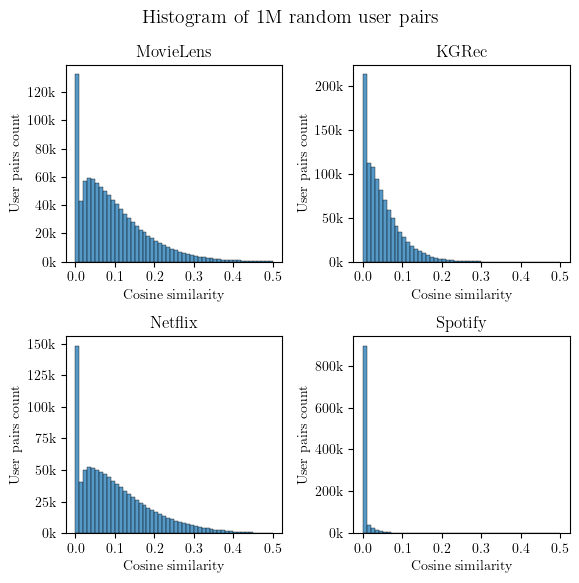

In [228]:
# draw historams for the datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#create 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(5.9, 5.9), dpi=100)

random_sample_size = 1_000_000
for i, dataset_sample in enumerate(datasets_samples.items()):
    dataset_name, samples_df = dataset_sample

    # get ith plot
    ax = axs[i//2, i%2]
    # fig, axs = plt.subplots(1, 1, figsize=(3.5, 2), dpi=100)

    # data are already grouped by bin, so we can use the same bins

    # non_zeros = samples_df[samples_df['similarity'] != 0]['similarity']
    sns.histplot(x=samples_df['similarity'], ax=ax, label='Cosine similarity', binwidth=0.01, binrange=(0, 0.5))
    # ax.bar_label(ax.containers[0])

    # highest_bar = 0
    # for i, bar in enumerate(axs.patches):
    #     bar_height = bar.get_height()
    #     if bar_height > highest_bar:
    #         highest_bar = bar_height
    #     percentage = bar_height / random_sample_size * 100
    #     format_string = "{0:.1f}"
    #     if percentage < 1:
    #         format_string = "{0:.2f}"
    #     if percentage < 0.1:
    #         format_string = "{0:.3f}"
    #     text = format_string.format(bar_height / random_sample_size * 100).lstrip('0')
    #     text2 = "{:,}".format(int(bar_height))
    #     # text = str(round(counts_cosine_df_grouped.iloc[i]['count'] / random_sample_size * 100, decimals)) + '%'
    #     axs.text(bar.get_x() + bar.get_width() / 2 + 0.007, bar.get_height(), text2 + '\n' + text + '\%' , ha='center', va='bottom', rotation=0)
    # # remove lines around the bars

    # sns.lineplot(x=exp_x, y=exp_pdf_y*random_sample_size/10, ax=axs, label='Exponential', color=colors[1])
    # ax.set_ylim(0, random_sample_size)
    # set tick text on y axes with percentage
    yticks_text = [str(round(x / 1000)) + 'k' for x in ax.get_yticks()]
    ax.set_yticklabels(yticks_text)

    ax.set_xticks(np.arange(0, 0.6, 0.1))
    ax.set_xlabel('Cosine similarity')
    ax.set_ylabel('User pairs count')
    ax.set_title(f"{dataset_name}")
    # axs.set_ylim(0, highest_bar * 1.18)

# heading over all subplots 
plt.suptitle('Histogram of 1M random user pairs', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/histogram_cosine_all.pdf', bbox_inches = 'tight', pad_inches=0.02)
plt.show()


In [229]:
dataset_inter_quartile_range = {}

for i, dataset_sample in enumerate(datasets_samples.items()):
    dataset_name, samples_df = dataset_sample

    non_zeros = samples_df[samples_df['similarity'] != 0]['similarity']

    non_zeros = non_zeros.sort_values()
    first_quartile = non_zeros.iloc[int(len(non_zeros) * 0.25)]
    median = non_zeros.iloc[int(len(non_zeros) * 0.5)]
    third_quartile = non_zeros.iloc[int(len(non_zeros) * 0.75)]

    width_of_interquartile_range = third_quartile - first_quartile
    print(f'{dataset_name}: {first_quartile:.3f}, {median:.3f}, {third_quartile:.3f}, {width_of_interquartile_range:.5f}')
    
    dataset_inter_quartile_range[dataset_name] = width_of_interquartile_range



MovieLens: 0.048, 0.090, 0.153, 0.10496
KGRec: 0.021, 0.044, 0.079, 0.05727
Netflix: 0.051, 0.098, 0.165, 0.11445
Spotify: 0.014, 0.023, 0.040, 0.02574


---
# Group generation

Now we have a fast way as how to calculate the similarity between pairs of users, we now implement the actual creation of groups

In [116]:
import ray

if ray.is_initialized():
    ray.shutdown()
# init ray with cores equal to the number of available cores
ray.init(num_cpus=os.cpu_count())

RayContext(dashboard_url='', python_version='3.9.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-30_00-14-51_796921_2182/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-30_00-14-51_796921_2182/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-30_00-14-51_796921_2182', 'metrics_export_port': 58948, 'gcs_address': '127.0.0.1:57630', 'address': '127.0.0.1:57630', 'node_id': '6c8c504e03154d960737920ff1807e6685f86a1df17c327639fa407c'})

In [117]:
def get_random_users(max):
    while True:
        u1, u2 = random.randint(0, max), random.randint(0, max)
        if u1 != u2:
            return u1, u2

@ray.remote
def calculate_similarity_ray(u1_ratings, u2_ratings):
    return calculate_similarity(u1_ratings, u2_ratings)

def calculate_similarity(u1_ratings, u2_ratings):
    u1_n = u1_ratings.dot(u1_ratings.T)[0, 0]
    if(u1_n == 0):
        return 0
    u2_n = u2_ratings.dot(u2_ratings.T)[0, 0]
    if(u2_n == 0):
        return 0
    denominator = np.sqrt(u1_n) * np.sqrt(u2_n)
    nomimator = u1_ratings.dot(u2_ratings.T)[0,0]
    result = nomimator / denominator
    return result

def draw_unique_candidates(max_id, num_of_candidates):
    return random.sample(range(max_id + 1), num_of_candidates)
    

def calculate_similarity_of_candidates(sparse_dataset, pivot_id, candidates_ids):
    ray_results = []
    ray_parameters = []
    
    pivot_ratings = sparse_dataset.getrow(pivot_id)
    for candidate_id in candidates_ids:
        candidate_ratings = sparse_dataset.getrow(candidate_id)
        ray_results.append(calculate_similarity_ray.remote(pivot_ratings, candidate_ratings))
        ray_parameters.append(candidate_id)

    results = ray.get(ray_results)
    return zip(ray_parameters, results)

def save_group_df(df, dataset_name, type, group_size, other_params):
    dir = os.path.join('dfs', 'groups', dataset_name)
    if not os.path.exists(dir):
        os.makedirs(dir)

    file_name = f'{type}_{group_size}'
    if other_params:
        file_name += '_' + '_'.join([f'{key}:{value}' for key,value in other_params.items()])
        
    df.to_csv(os.path.join(dir, f'{file_name}.csv'), index=False)

## Generate random groups

In [167]:
def generate_random_groups(group_size, num_of_groups_to_generate):
    for dataset_name, dataset_df, _ in ratings_datasets_w_sparse:
        print(f"Generating random groups for {dataset_name}")
        max_user_id = dataset_df['user_id'].max()
        groups = [draw_unique_candidates(max_user_id, group_size) for _ in range(num_of_groups_to_generate)]

        df = pd.DataFrame(groups)
        save_group_df(df, dataset_name=dataset_name, type='random', group_size=group_size, other_params=None)

## Generate top-k groups

In [171]:
def generate_top_k_groups(group_size, num_of_groups_to_generate, number_of_candidates=1000):
    for dataset_name, dataset_df, ratings_sparse in ratings_datasets_w_sparse:
        print(f"Generating top-k groups for {dataset_name}")
        max_user_id = dataset_df['user_id'].max()
        groups = []
        for _ in tqdm(range(num_of_groups_to_generate), total=num_of_groups_to_generate):
            # draw one more which will become the pivot
            candidates = draw_unique_candidates(max_user_id, number_of_candidates + 1)
            pivot, candidates = candidates[0], candidates[1:]
            # calculate the similarity of the pivot to all the candidates
            candidates_similarities = calculate_similarity_of_candidates(ratings_sparse, pivot, candidates)
            # sort the candidates by similarity
            candidates_similarities = sorted(candidates_similarities, key=lambda x: x[1], reverse=True)
            # take the top k candidates
            top_k_candidates = [x[0] for x in candidates_similarities[:group_size - 1]]
            group = [pivot] + top_k_candidates
            groups.append(group)


        df = pd.DataFrame(groups)
        # other_params = {'number_of_candidates': number_of_candidates}
        save_group_df(df, dataset_name=dataset_name, type='top_k', group_size=group_size, other_params=None)
        print('Groups saved')

## Generate weighted groups

In [199]:

# weighted_groups = {}

# interval width is N in the thesis
# exp_params is lambda
# scaling_exponent and scaling_width are M and D respectively
def calculate_weight(similarity, exp_params, scaling_exponent, scaling_width):
    scaling = scaling_exponent ** (similarity / scaling_width)

    # start = similarity
    # end = similarity + interval_width
    # prob_on_interval = ss.expon.cdf(end, *exp_params) - ss.expon.cdf(start, *exp_params)
    # if(prob_on_interval == 0):
    #     print(f"ding {similarity} - {ss.expon.cdf(end, *exp_params)} - {ss.expon.cdf(start, *exp_params)} = {prob_on_interval * 1000_000}")
    #     return 0
    # weight = scaling / prob_on_interval
    
    prob_ratio = ss.expon.pdf(similarity, *exp_params)
    weight = scaling / prob_ratio
    return weight

def generate_weighted_groups(group_size, num_of_groups_to_generate, scaling_exponent, scaling_width = None, number_of_candidates=1000, top_k = False):
    for dataset_name, dataset_df, ratings_sparse in ratings_datasets_w_sparse:
        # if dataset_name != 'MovieLens':
            # continue

        dataset_exp_params = datasets_modeled_params[dataset_name]

        if scaling_width is None:
            inter_quartile_range = dataset_inter_quartile_range[dataset_name]
        else:
            inter_quartile_range = scaling_width
        
        print(f"Generating weighted groups for {dataset_name}")
        max_user_id = dataset_df['user_id'].max()
        groups_weighted = []
        groups_top_k = []
        for _ in tqdm(range(num_of_groups_to_generate), total=num_of_groups_to_generate):
            # draw one more which will become the pivot
            candidates = draw_unique_candidates(max_user_id, number_of_candidates + 1)
            pivot, candidates = candidates[0], candidates[1:]
            assert len(candidates) == number_of_candidates
            # calculate the similarity of the pivot to all the candidates
            candidates_similarities = calculate_similarity_of_candidates(ratings_sparse, pivot, candidates)

            candidates_similarities_w_weights = []
            for candidate_id, similarity in candidates_similarities:
                weight = calculate_weight(similarity, dataset_exp_params, scaling_exponent, scaling_width=inter_quartile_range)
                candidates_similarities_w_weights.append((candidate_id, similarity, weight))

            # take k candidates with respect to weights
            candidates = [x[0] for x in candidates_similarities_w_weights]
            weights = [x[2] for x in candidates_similarities_w_weights]
            weights = np.array(weights) / sum(weights)

            selected_weighted = list(np.random.choice(candidates, size=group_size - 1, p=weights, replace=False))

            ordered_candidates = sorted(candidates_similarities_w_weights, key=lambda x: x[1], reverse=True)
            if top_k:
                selected_top_k = ordered_candidates[:group_size - 1]
                selected_top_k = [x[0] for x in selected_top_k]

                group_top_k = [pivot] + selected_top_k
                assert len(group_top_k) == group_size
                groups_top_k.append(group_top_k)

            # assert len(selected_weighted) == len(selected_top_k)
            group_weighted = [pivot] + selected_weighted
            assert len(group_weighted) == group_size
            groups_weighted.append(group_weighted)

        if top_k:
            df_top_k = pd.DataFrame(groups_top_k)
            save_group_df(df_top_k, type='top_k', dataset_name=dataset_name, group_size=group_size, other_params={'noc': number_of_candidates})


        df_weighted = pd.DataFrame(groups_weighted)
        other_params = {'se': scaling_exponent}
        save_group_df(df_weighted, type='weighted', dataset_name=dataset_name, group_size=group_size, other_params=other_params)

        print('Groups saved')


In [200]:
group_size = 5
num_of_groups_to_generate = 50

generate_random_groups(group_size=group_size,num_of_groups_to_generate=num_of_groups_to_generate)
generate_top_k_groups(group_size, num_of_groups_to_generate)


for scaling_exponent in [0.5, 1, 2, 4, 8]:
    generate_weighted_groups(
        group_size=group_size,
        num_of_groups_to_generate=num_of_groups_to_generate,
        scaling_exponent=scaling_exponent,
        scaling_width=0.1,
        )



Generating random groups for KGRec
Generating random groups for MovieLens
Generating random groups for Netflix
Generating random groups for Spotify
Generating top-k groups for KGRec


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Groups saved
Generating top-k groups for MovieLens


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Groups saved
Generating top-k groups for Netflix


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Groups saved
Generating top-k groups for Spotify


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Groups saved
Generating weighted groups for KGRec


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Groups saved
Generating weighted groups for MovieLens


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Groups saved
Generating weighted groups for Netflix


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


Groups saved
Generating weighted groups for Spotify


100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


Groups saved
Generating weighted groups for KGRec


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Groups saved
Generating weighted groups for MovieLens


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


Groups saved
Generating weighted groups for Netflix


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


Groups saved
Generating weighted groups for Spotify


100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Groups saved
Generating weighted groups for KGRec


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


Groups saved
Generating weighted groups for MovieLens


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


Groups saved
Generating weighted groups for Netflix


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


Groups saved
Generating weighted groups for Spotify


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Groups saved
Generating weighted groups for KGRec


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


Groups saved
Generating weighted groups for MovieLens


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


Groups saved
Generating weighted groups for Netflix


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


Groups saved
Generating weighted groups for Spotify


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Groups saved
Generating weighted groups for KGRec


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


Groups saved
Generating weighted groups for MovieLens


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


Groups saved
Generating weighted groups for Netflix


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Groups saved
Generating weighted groups for Spotify


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]

Groups saved


---
## Load the generated groups and analyze them

In [187]:
import itertools

def calculate_similarity_in_group(group, ratings_datasets):
    similarities = []
    for u1, u2 in itertools.combinations(group, 2):
        u1_ratings = ratings_datasets.getrow(u1)
        u2_ratings = ratings_datasets.getrow(u2)
        similarity = calculate_similarity(u1_ratings, u2_ratings)
        similarities.append(similarity)
    return similarities

def calculate_similarity_with_pivot(group, ratings_datasets):
    similarities = []
    # for u1, u2 in itertools.combinations(group, 2):
    u2 = group[0]
    u2_ratings = ratings_datasets.getrow(u2)
    for u1 in group[1:]:
        u1_ratings = ratings_datasets.getrow(u1)
        similarity = calculate_similarity(u1_ratings, u2_ratings)
        similarities.append(similarity)
    # print(similarities)
    return similarities

def calculate_similarity_for_dataset(groups_dataset_df, ratings_sparse):
    groups_similarities_means = []
    groups_similarities_vars = []

    group_similarities_pivot_mean = []
    group_similarities_pivot_var = []

    for row in tqdm(groups_dataset_df.itertuples(), total=groups_dataset_df.shape[0]):
        group = list(row)[1:]
        group_similarities = calculate_similarity_in_group(group, ratings_sparse)
        # print(f"Random group {group[1]} has similarities {group_similarities}")
        groups_similarities_means.append(np.mean(group_similarities))
        groups_similarities_vars.append(np.var(group_similarities))

        group_similarities_pivot = calculate_similarity_with_pivot(group, ratings_sparse)

        group_similarities_pivot_mean.append(np.mean(group_similarities_pivot))
        group_similarities_pivot_var.append(np.var(group_similarities_pivot))
    
    return groups_similarities_means, groups_similarities_vars, group_similarities_pivot_mean, group_similarities_pivot_var

In [188]:

# for dataset_name, dataset_df, ratings_sparse in ratings_datasets_w_sparse:
#     print(dataset_name)
#     for type in ['random', 'weighted', 'top_k']:
#         groups_df = pd.read_csv(os.path.join('dfs', 'groups', f'{type}_{num_of_groups_to_generate}_{dataset_name}.csv'))
#         means, variances, pivot_means, pivot_vars = calculate_similarity_for_dataset(groups_df, ratings_sparse)

#         print(f"{type}".ljust(9)+ f" mean_mean {'{0:.4f}'.format(np.mean(means))} and mean_variance {'{0:.4f}'.format(np.mean(variances))}")
#     print()

---
# Visualize the weighted scaling parameter results

In [201]:
group_size = 5
load_group_size = 5

file_names = [
    (f'random_{group_size}', 'random_groups'),
    *[(f'weighted_{group_size}_se:{exp}', f'weighted_groups_{exp}') for exp in [0.5, 1, 2, 4, 8]],
    (f'top_k_{group_size}', 'top_k_groups')
]


results = []
for dataset_name, dataset_df, ratings_sparse in ratings_datasets_w_sparse:
    print(dataset_name)
    for file_name, name in file_names:
        print(f'Processing: {file_name}')
        groups_df = pd.read_csv(os.path.join('dfs', 'groups', dataset_name , f'{file_name}.csv'))
        groups_df = groups_df.iloc[:, :load_group_size]
        assert len(groups_df.columns) == load_group_size
        
        means, variances, pivot_means, pivot_vars = calculate_similarity_for_dataset(groups_df, ratings_sparse)
        # append the data to results
        results.append({
            'dataset_name': dataset_name,
            'name': name,
            'intergroup_means': means,
            'intergroup_variances': variances,
            'pivot_means': pivot_means,
            'pivot_variances': pivot_vars
        })
        
# create datafrale from results
results_df = pd.DataFrame(results)
# create dir
if not os.path.exists('dfs/results'):
    os.makedirs('dfs/results')
results_df.to_csv(os.path.join('dfs', 'results', f'inter_group_means_{group_size}_{load_group_size}.csv'), index=False)

KGRec
Processing: random_5


100%|██████████| 50/50 [00:00<00:00, 202.87it/s]


Processing: weighted_5_se:0.5


100%|██████████| 50/50 [00:00<00:00, 205.50it/s]


Processing: weighted_5_se:1


100%|██████████| 50/50 [00:00<00:00, 206.30it/s]


Processing: weighted_5_se:2


100%|██████████| 50/50 [00:00<00:00, 207.39it/s]


Processing: weighted_5_se:4


100%|██████████| 50/50 [00:00<00:00, 207.36it/s]


Processing: weighted_5_se:8


100%|██████████| 50/50 [00:00<00:00, 208.15it/s]


Processing: top_k_5


100%|██████████| 50/50 [00:00<00:00, 207.18it/s]


MovieLens
Processing: random_5


100%|██████████| 50/50 [00:00<00:00, 158.75it/s]


Processing: weighted_5_se:0.5


100%|██████████| 50/50 [00:00<00:00, 157.74it/s]


Processing: weighted_5_se:1


100%|██████████| 50/50 [00:00<00:00, 158.01it/s]


Processing: weighted_5_se:2


100%|██████████| 50/50 [00:00<00:00, 157.21it/s]


Processing: weighted_5_se:4


100%|██████████| 50/50 [00:00<00:00, 157.23it/s]


Processing: weighted_5_se:8


100%|██████████| 50/50 [00:00<00:00, 156.01it/s]


Processing: top_k_5


100%|██████████| 50/50 [00:00<00:00, 158.27it/s]


Netflix
Processing: random_5


100%|██████████| 50/50 [00:00<00:00, 191.02it/s]


Processing: weighted_5_se:0.5


100%|██████████| 50/50 [00:00<00:00, 191.92it/s]


Processing: weighted_5_se:1


100%|██████████| 50/50 [00:00<00:00, 189.06it/s]


Processing: weighted_5_se:2


100%|██████████| 50/50 [00:00<00:00, 177.62it/s]


Processing: weighted_5_se:4


100%|██████████| 50/50 [00:00<00:00, 187.82it/s]


Processing: weighted_5_se:8


100%|██████████| 50/50 [00:00<00:00, 188.83it/s]


Processing: top_k_5


100%|██████████| 50/50 [00:00<00:00, 190.95it/s]


Spotify
Processing: random_5


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Processing: weighted_5_se:0.5


100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


Processing: weighted_5_se:1


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Processing: weighted_5_se:2


100%|██████████| 50/50 [00:03<00:00, 13.25it/s]


Processing: weighted_5_se:4


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


Processing: weighted_5_se:8


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Processing: top_k_5


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


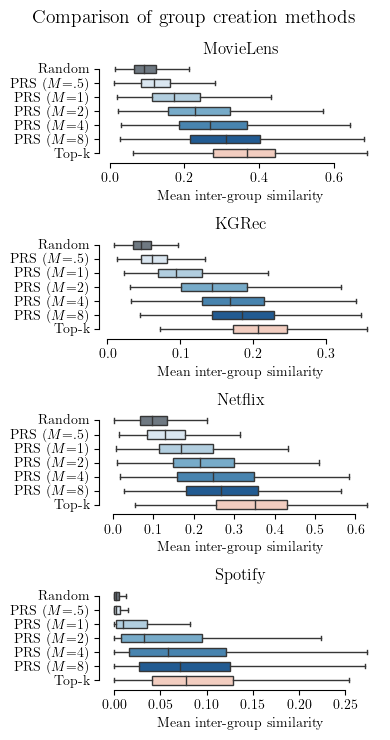

In [235]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    })

import seaborn as sns

results_df = pd.read_csv(os.path.join('dfs', 'results', 'inter_group_means_10_5.csv'))

results_df['intergroup_variances'] = results_df['intergroup_variances'].apply(lambda x: list(eval(x)))
results_df['intergroup_means'] = results_df['intergroup_means'].apply(lambda x: list(eval(x)))
results_df['pivot_means'] = results_df['pivot_means'].apply(lambda x: list(eval(x)))
results_df['pivot_variances'] = results_df['pivot_variances'].apply(lambda x: list(eval(x)))


x_df = results_df[['dataset_name', 'name', 'intergroup_means']].explode('intergroup_means')
x_df['intergroup_means'] = x_df['intergroup_means'].astype(float)


# map names
map_dict = {
    'random_groups': 'Random',
    'top_k_groups': 'Top-k'
}
exps = [0.5, 1, 2, 4, 8]
for exp in exps:
    exp_param = f'($M$={str(exp).strip("0")})'
    map_dict[f'weighted_groups_{exp}'] = f'PRS {exp_param}'
x_df['name'] = x_df['name'].map(map_dict)

colors = [
    '#6C7985',
    *sns.color_palette('Blues', n_colors=len(exps)).as_hex(),
    '#FAC9B8',
]


fig, axs = plt.subplots(4, 1, figsize=(4, 7.5), dpi=100)
# fig, axs = plt.subplots(2, 2, figsize=(5.7, 4), dpi=100)


for i, dataset_name in enumerate(dataset_names):
    ax = axs[i]
    # ax = axs[i//2, i%2]

    data=x_df[x_df['dataset_name'] == dataset_name]
    sns.boxplot(y="name", x="intergroup_means",
                data=data,
                ax=ax, orient='h', width=.6, palette=colors, showfliers = False, linewidth=1)
    ax.set_ylabel('')
    # set title centered on the whole figure
    ax.set_title(dataset_name, loc='center', fontsize=12)

    sns.despine(offset=2, trim=True, ax=ax)

    ax.set_xlabel('Mean inter-group similarity')
    # if(i == len(dataset_names) - 1):
    #     ax.set_xlabel('Mean intergroup similarity')
    # else:
    #     ax.set_xlabel('')


plt.suptitle('Comparison of group creation methods', fontsize=14, y=0.98)
plt.tight_layout()
# plt.savefig(os.path.join('..', 'figures', 'inter_group_means.png'), dpi=300)
plt.savefig(os.path.join('..', 'figures', 'inter_group_means.pdf'), bbox_inches = 'tight', pad_inches=0.02)